# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [175]:
import numpy as np
import os
#from scipy.misc import imread, imresize, 1.2
from skimage.transform import resize
from imageio import imread
from skimage.io import imshow
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [136]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf # version 2
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [137]:
train_doc = np.random.permutation(open('../input/gesturerecognitionpriyeshraj17/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesturerecognitionpriyeshraj17/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [138]:
# Filters

def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [189]:
x = 30 # Number of images per video
y = 80 # Height of the image
z = 80 # width of the image

In [190]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]#create a list of image numbers you want to use for a particular video
    img_idx = list(range(6, 24))
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, x, y, z ,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    final_image = resize(image, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB x,y,z = 18,84,84
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    final_image = resize(image, (y, z, 3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder, idx, :,:,:] = final_image
                    
                    batch_data[folder,idx,:,:,0] = batch_data[folder,idx,:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = batch_data[folder,idx,:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = batch_data[folder,idx,:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [191]:
curr_dt_time = datetime.datetime.now()
train_path = '../input/gesturerecognitionpriyeshraj17/Project_data/train'
val_path = '../input/gesturerecognitionpriyeshraj17/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 #Selecting 10 as number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [192]:
# check complete batch shape
sample_train_generator = generator(train_path, train_doc, 32)
sample_batch_data, sample_batch_labels = next(sample_train_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, 32)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


(32, 30, 80, 80, 3)
Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/val ; batch size = 32
(32, 30, 80, 80, 3)


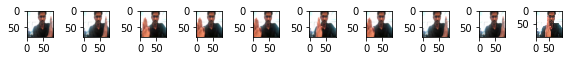

In [193]:
# plot generated sample images
fig, ax = plt.subplots(1,10)

for i in range(10):
    ax[i].imshow(sample_val_batch_data[0,i,:,:,:])
    imshow(resize(sample_val_batch_data[0,i,:,:,:], (100,100,3)))
    
#plt.show()

In [151]:
# Utility function to plot model history.
def plot_history_for_model(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('No. of Epochs')
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('No. of Epochs')
    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validation Accuracy", max(h.history['val_categorical_accuracy']))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [152]:
from keras.models import Sequential, Model
from keras.layers import (Dense, GRU, Flatten, TimeDistributed, Flatten, 
BatchNormalization, Activation, Dropout, LSTM)
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [194]:
model_name = 'Gesture_Recognition_Runs' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [154]:
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# This model is always going beyond the memory and crashing the system. 

The commented out model is always going beyond the memory and crashing the system. Tried both Collab and Kaggle. It needs a *proper tradeoff between image size and no. of frames.*
Need to define new model with experiments in batch size.

#### Batch Size 32 seems optimal.

### Model 1. 
Trying: 
Epochs: 20

In [195]:
inputShape = Input_shape = (x, y, z, 3)

In [156]:
num_epochs = 20
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model1 = Sequential([
    Conv3D(32, make3dFilter(3), activation='relu', input_shape=inputShape),
    #MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    Dropout(0.5),

    #Conv3D(64, make3dFilter(3), activation='relu'),
    #BatchNormalization(),
    #MaxPooling3D(pool_size=(1,2,2), padding='same'),
    
    Conv3D(64, make3dFilter(3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_67 (Conv3D)           (None, 16, 78, 78, 32)    2624      
_________________________________________________________________
batch_normalization_134 (Bat (None, 16, 78, 78, 32)    128       
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 14, 76, 76, 32)    27680     
_________________________________________________________________
batch_normalization_135 (Bat (None, 14, 76, 76, 32)    128       
_________________________________________________________________
max_pooling3d_63 (MaxPooling (None, 14, 38, 38, 32)    0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 14, 38, 38, 32)    0         
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 12, 36, 36, 64)    553

In [157]:
model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list ,validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/20
19/21 [==========================>...] - ETA: 12s - loss: 1.8308 - categorical_accuracy: 0.4342

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


21/21 [==============================] - 153s 8s/step - loss: 1.7913 - categorical_accuracy: 0.4434 - val_loss: 2.6457 - val_categorical_accuracy: 0.1900
Epoch 2/20
21/21 [==============================] - 105s 5s/step - loss: 0.7892 - categorical_accuracy: 0.7134 - val_loss: 11.1877 - val_categorical_accuracy: 0.1600
Epoch 3/20
21/21 [==============================] - 108s 5s/step - loss: 0.4694 - categorical_accuracy: 0.8250 - val_loss: 18.1040 - val_categorical_accuracy: 0.1700
Epoch 4/20
21/21 [==============================] - 103s 5s/step - loss: 0.2717 - categorical_accuracy: 0.9186 - val_loss: 22.1610 - val_categorical_accuracy: 0.2000
Epoch 5/20
21/21 [==============================] - 106s 5s/step - loss: 0.1546 - categorical_accuracy: 0.9397 - val_loss: 24.5667 - val_categorical_accuracy: 0.2100

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
21/21 [==============================] - 106s 5s/step - loss: 0.0971 - categorical_accura

The changes in batch processing logic seems to do the trick. The accuracies are improving. Cat accuracy 0.99 and Validation accuracy: 0.23

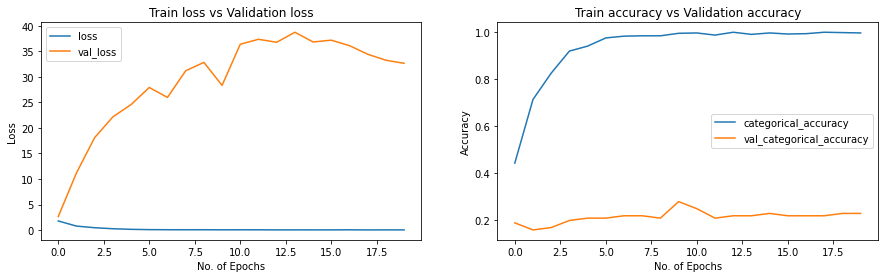

Max. Training Accuracy 0.9984917044639587
Max. Validation Accuracy 0.2800000011920929


In [158]:
plot_history_for_model(model1_history)

#### The Selected Model 

In [196]:
# Changing architecture and reducing number of params.
num_epochs = 21
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model2 = Sequential([
    Conv3D(32, (3,3,3), padding="same", input_shape=(x,y,z,3)),
    BatchNormalization(),
    Activation("elu"),
    MaxPooling3D(pool_size=(2,2,2)),
    
    Conv3D(64, (3,3,3), padding="same"),
    BatchNormalization(),
    Activation("elu"),
    MaxPooling3D(pool_size=(3,4,4)),
    
    Flatten(),
    Dense(192, activation="relu"),
    Dropout(0.35),
    
    Dense(5, activation="softmax")
], name="conv_3d2")

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

Model: "conv_3d2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_78 (Conv3D)           (None, 30, 80, 80, 32)    2624      
_________________________________________________________________
batch_normalization_146 (Bat (None, 30, 80, 80, 32)    128       
_________________________________________________________________
activation_14 (Activation)   (None, 30, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 15, 40, 40, 32)    0         
_________________________________________________________________
conv3d_79 (Conv3D)           (None, 15, 40, 40, 64)    55360     
_________________________________________________________________
batch_normalization_147 (Bat (None, 15, 40, 40, 64)    256       
_________________________________________________________________
activation_15 (Activation)   (None, 15, 40, 40, 64)    0  

In [197]:
model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/21
19/21 [==========================>...] - ETA: 9s - loss: 2.5551 - categorical_accuracy: 0.2895 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


21/21 [==============================] - 117s 6s/step - loss: 2.4672 - categorical_accuracy: 0.2941 - val_loss: 1.5932 - val_categorical_accuracy: 0.1900

Epoch 00001: saving model to Gesture_Recognition_Runs_2022-10-1216_55_02.506525/model-00001-2.46718-0.29412-1.59325-0.19000.h5
Epoch 2/21
21/21 [==============================] - 104s 5s/step - loss: 1.4076 - categorical_accuracy: 0.3801 - val_loss: 1.5955 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to Gesture_Recognition_Runs_2022-10-1216_55_02.506525/model-00002-1.40756-0.38009-1.59552-0.19000.h5
Epoch 3/21
21/21 [==============================] - 107s 5s/step - loss: 1.3010 - categorical_accuracy: 0.4148 - val_loss: 1.4347 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to Gesture_Recognition_Runs_2022-10-1216_55_02.506525/model-00003-1.30100-0.41478-1.43472-0.35000.h5
Epoch 4/21
21/21 [==============================] - 102s 5s/step - loss: 1.2041 - categorical_accuracy: 0.4465 - val_loss: 1.4849 - 

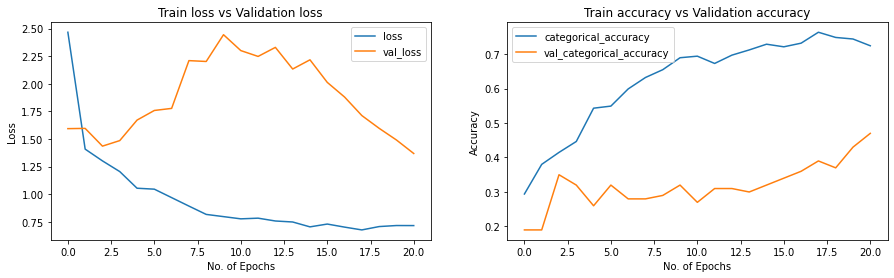

Max. Training Accuracy 0.7631976008415222
Max. Validation Accuracy 0.4699999988079071


In [198]:
plot_history_for_model(model2_history)

#### Other tried models. Not selected in final outcome

In [118]:
# Let's reduce the parameters and increase the epochs and observe the trend
num_epochs = 20
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model3 = Sequential([
        Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())


Model: "conv_3d3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_54 (Conv3D)           (None, 18, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_50 (MaxPooling (None, 9, 50, 50, 16)     0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 9, 50, 50, 16)     64        
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 9, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_51 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 5, 25, 25, 64)     553

In [119]:
model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/20
21/21 [==============================] - 6s 213ms/step - loss: 1.9372 - categorical_accuracy: 0.2692 - val_loss: 1.5793 - val_categorical_accuracy: 0.2857
Epoch 2/20
21/21 [==============================] - 2s 106ms/step - loss: 1.6100 - categorical_accuracy: 0.2381 - val_loss: 2.0029 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 2s 89ms/step - loss: 1.4252 - categorical_accuracy: 0.4400 - val_loss: 5.4076 - val_categorical_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 3s 170ms/step - loss: 2.1626 - categorical_accuracy: 0.2381 - val_loss: 241.9422 - val_categorical_accuracy: 0.2500
Epoch 5/20
21/21 [==============================] - 3s 165ms/step - loss: 1.9745 - categorical_accuracy: 0.3095 - val_loss: 308.1345 - val_categorical_accuracy: 0.2500

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
21/21 [==============================] - 3s 141ms/step - loss: 2.1

Epochs don't see to affect the accuracy much

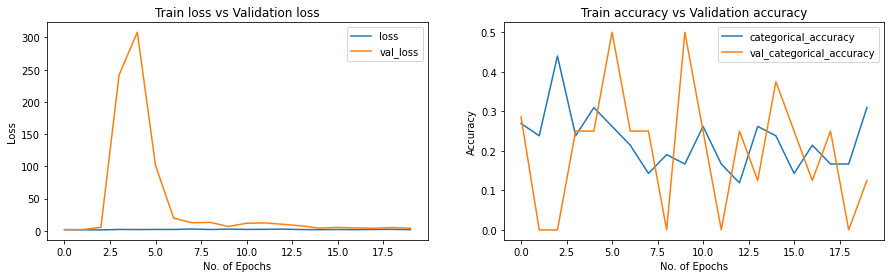

Max. Training Accuracy 0.4399999976158142
Max. Validation Accuracy 0.5


In [120]:
plot_history_for_model(model3_history)

In [121]:
# Lets try with another architecture where same pooling is used in all 3 layers. It reduces the
# number of parameters even further.
num_epochs = 20
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

Model: "conv_3d4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 18, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 9, 50, 50, 16)     0         
_________________________________________________________________
batch_normalization_112 (Bat (None, 9, 50, 50, 16)     64        
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 9, 50, 50, 32)     13856     
_________________________________________________________________
max_pooling3d_54 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 5, 25, 25, 64)     553

In [122]:
model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/20
21/21 [==============================] - 6s 235ms/step - loss: 2.1365 - categorical_accuracy: 0.0962 - val_loss: 1.6156 - val_categorical_accuracy: 0.2571
Epoch 2/20
21/21 [==============================] - 2s 77ms/step - loss: 1.6013 - categorical_accuracy: 0.1905 - val_loss: 1.6550 - val_categorical_accuracy: 0.5000
Epoch 3/20
21/21 [==============================] - 2s 101ms/step - loss: 1.8424 - categorical_accuracy: 0.1600 - val_loss: 5.0724 - val_categorical_accuracy: 0.7500
Epoch 4/20
21/21 [==============================] - 3s 146ms/step - loss: 1.9643 - categorical_accuracy: 0.2381 - val_loss: 1909.5004 - val_categorical_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 3s 153ms/step - loss: 2.6173 - categorical_accuracy: 0.1667 - val_loss: 232.6874 - val_categorical_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
21/21 [==============================] - 3s 156ms/step - loss: 1.9773

All 3 models are coming to 12% validation accuracy.

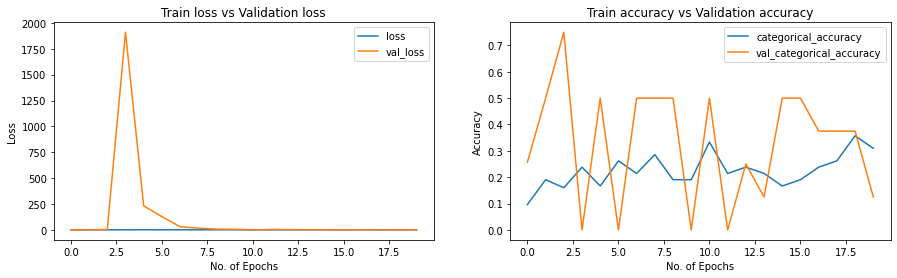

Max. Training Accuracy 0.3571428656578064
Max. Validation Accuracy 0.75


In [123]:
plot_history_for_model(model4_history)

Let's try some other models like Conv2d with LSTM 

In [124]:
# Trying Conv2D with LSTM
num_epochs = 25
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_80 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_81 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_82 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_83 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_84 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_85 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 18, 25, 25, 64)   

In [125]:
model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/25
21/21 [==============================] - 8s 231ms/step - loss: 1.7241 - categorical_accuracy: 0.1538 - val_loss: 1.6284 - val_categorical_accuracy: 0.2286
Epoch 2/25
21/21 [==============================] - 2s 95ms/step - loss: 1.6524 - categorical_accuracy: 0.1905 - val_loss: 1.5633 - val_categorical_accuracy: 0.2500
Epoch 3/25
21/21 [==============================] - 2s 110ms/step - loss: 1.8349 - categorical_accuracy: 0.2000 - val_loss: 1.5118 - val_categorical_accuracy: 0.5000
Epoch 4/25
21/21 [==============================] - 3s 150ms/step - loss: 1.6347 - categorical_accuracy: 0.2143 - val_loss: 1.6240 - val_categorical_accuracy: 0.2500
Epoch 5/25
21/21 [==============================] - 3s 145ms/step - loss: 1.8342 - categorical_accuracy: 0.1667 - val_loss: 1.5543 - val_categorical_accuracy: 0.2500
Epoch 6/25
21/21 [==============================] - 4s 182ms/step - loss: 1.6788 - categorical_accuracy: 0.1905 - val_loss: 1.6043 - val_categorical_accuracy: 0.5000
Epoch

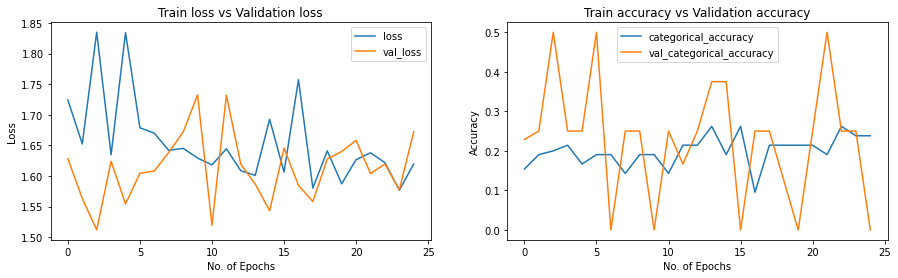

Max. Training Accuracy 0.261904776096344
Max. Validation Accuracy 0.5


In [126]:
plot_history_for_model(model6_history)

The accuracy is not changing. Not sure why.

In [127]:
# Lets try with less number of params
num_epochs = 20
batch_size = 32

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(2), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.25),

    Dense(256, activation='relu'),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_2d_lstm_reduced_params")
model7.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
               loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "conv_2d_lstm_reduced_params"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_97 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_98 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_99 (TimeDis (None, 18, 50, 50, 32)    2080      
_________________________________________________________________
time_distributed_100 (TimeDi (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_101 (TimeDi (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_102 (TimeDi (None, 18,

In [128]:
model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesturerecognitionpriyeshraj17/Project_data/train ; batch size = 32


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


Epoch 1/20
21/21 [==============================] - 7s 218ms/step - loss: 1.6835 - categorical_accuracy: 0.1923 - val_loss: 1.6172 - val_categorical_accuracy: 0.1714
Epoch 2/20
21/21 [==============================] - 2s 81ms/step - loss: 1.7880 - categorical_accuracy: 0.2857 - val_loss: 1.6213 - val_categorical_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 2s 91ms/step - loss: 1.9830 - categorical_accuracy: 0.1600 - val_loss: 1.7306 - val_categorical_accuracy: 0.2500
Epoch 4/20
21/21 [==============================] - 3s 159ms/step - loss: 1.7110 - categorical_accuracy: 0.2857 - val_loss: 1.7224 - val_categorical_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 4s 180ms/step - loss: 1.6595 - categorical_accuracy: 0.2857 - val_loss: 1.6449 - val_categorical_accuracy: 0.0000e+00

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
21/21 [==============================] - 4s 176ms/step - loss: 1.86

Validation accuracy seems to be plateuaing at 25%.

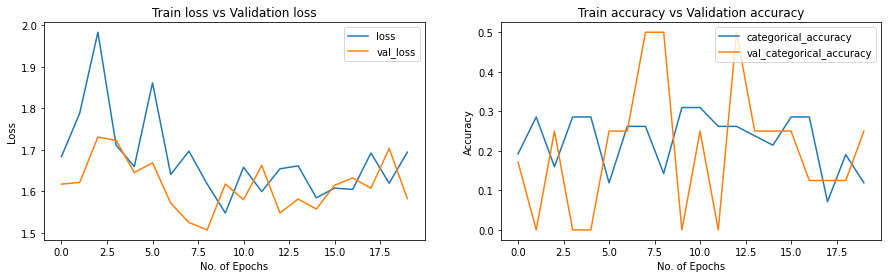

Max. Training Accuracy 0.3095238208770752
Max. Validation Accuracy 0.5


In [129]:
plot_history_for_model(model7_history)

In [31]:
# import os
# import shutil
# import glob

# dirs = glob.glob("/kaggle/working/*")

# for file in dirs:
#     if ".ipynb" in file:
#         continue
    
#     print(file)
#     shutil.rmtree(file)
    

/kaggle/working/Gesture_Recognition_Runs_2022-10-1210_10_58.782941
